In [1]:
%load_ext autoreload
%autoreload 2

Hereafer I will import some of the python libraries I will use in the solution:

In [2]:
import numpy as np
import pandas as pd
import logging
import os, sys
from functools import partial
import yaml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import logging
from scipy.optimize import curve_fit

I am defining the logger, I will use it to print some information about the execution:

In [3]:
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%d/%m/%Y %I:%M:%S%p")

logger = logging.getLogger(__name__)

# Subscriptions

In [4]:
from source.subscriptions import subscriptionModel

First of all I will load the data:

In [5]:
subscriptions_model = subscriptionModel()

In [6]:
data_subscriptions = pd.read_csv(os.path.join("data", "data_subscriptions.csv"))\
            [['renewals','T','N']].sort_values(by='renewals')

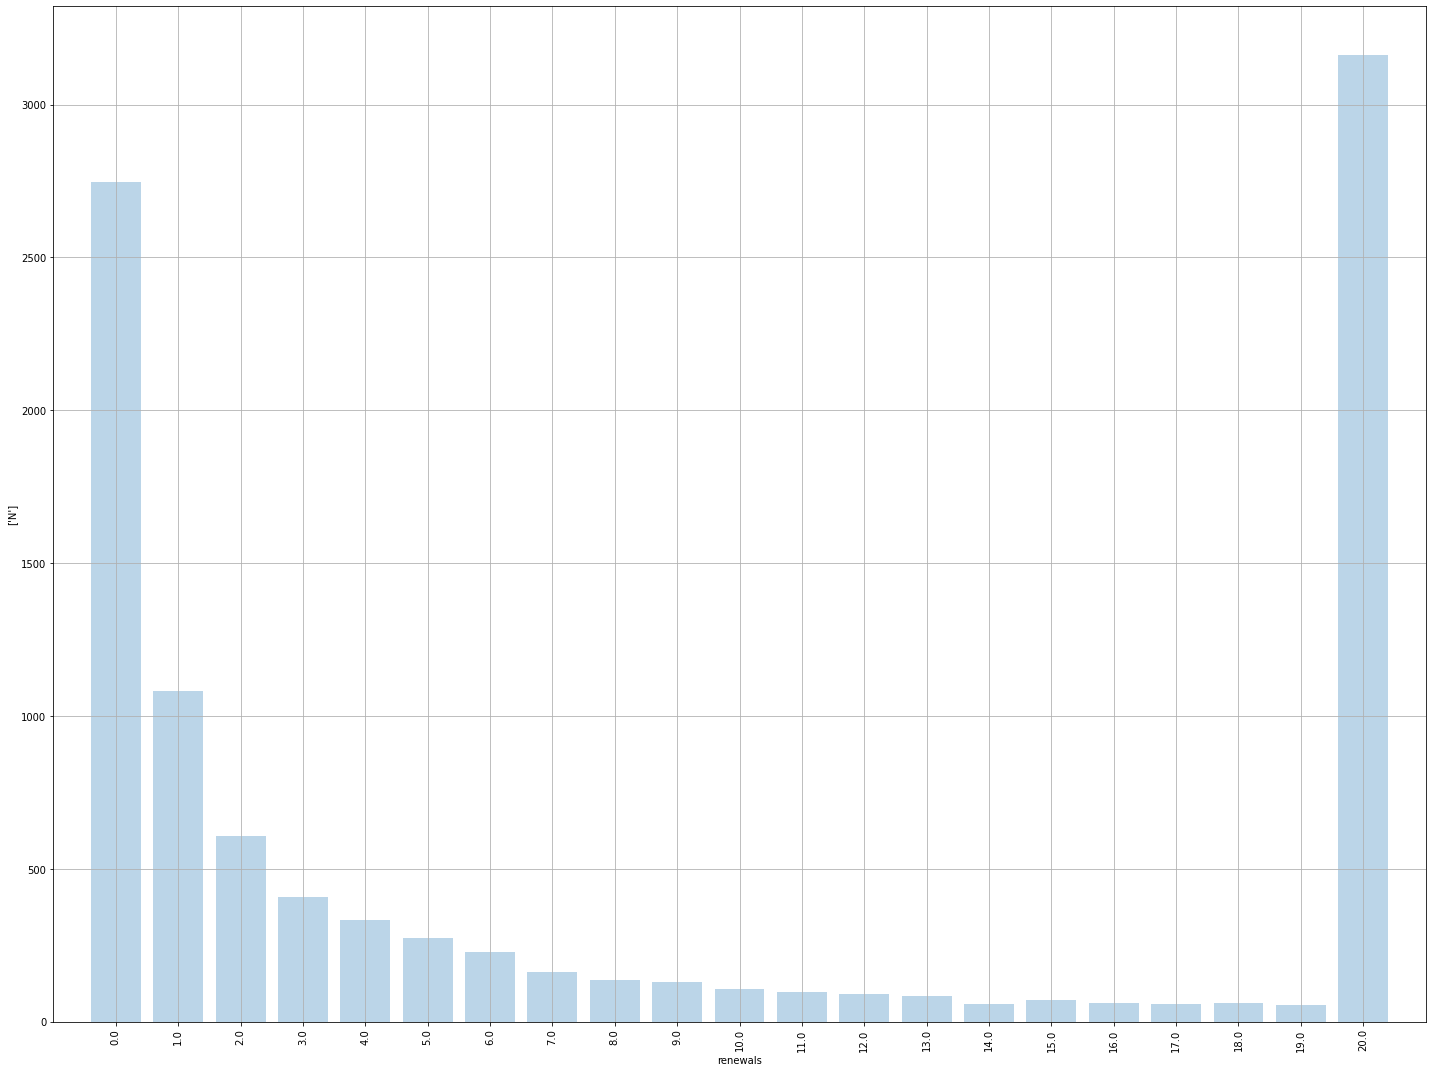

In [7]:
subscriptions_model.plot(data_subscriptions)

Let's assume that a customer have an active subscription to our app at $t_0$. According to our model, this customer will be active at time $t_1$ with probability $1-p$. If he is actually active at time $t_1$, the probability that he will have an active contract at $t_2$ is again $1-p$. So, the probability that a customer active at $t_0$ will be active also at $t_2$ is given by $(1-p)(1-p) = (1-p)^2$.

Generalizing this reasoning, we can assume that the probability that a customer is still active after $N$ timestep is $(1-p)^N$.

Let's assume that $N = 20$, as in the example above. The probability to have a customer with $renewals = 20$ is given by the formula $P(t_{20}) = (1-p)^{20}$.

The probability that a customer will have $renewals = 19$ is given by the joint probability of the two event:

1. the customer is still active at $t_{19}$
2. the customer unsubscribed before $t_{20}$

that is given by $P(t_{19})p = p (1-p)^{19}$. Let's write our function in the most general case:

In [8]:
def simulate(N, p, T):
    if N==T:
        return (1-p)**N
    else:
        return p*(1-p)**(N-1)

Let's use this function to simulate the behavior of a sample of 10000 customers for 20 billing periods (the same values of the given dataset). I will choose a value of $p = 0.125$:

In [9]:
simulations = subscriptions_model.simulate(p=0.125, T=20, N_customers=10000)

Let's take a look of the results:

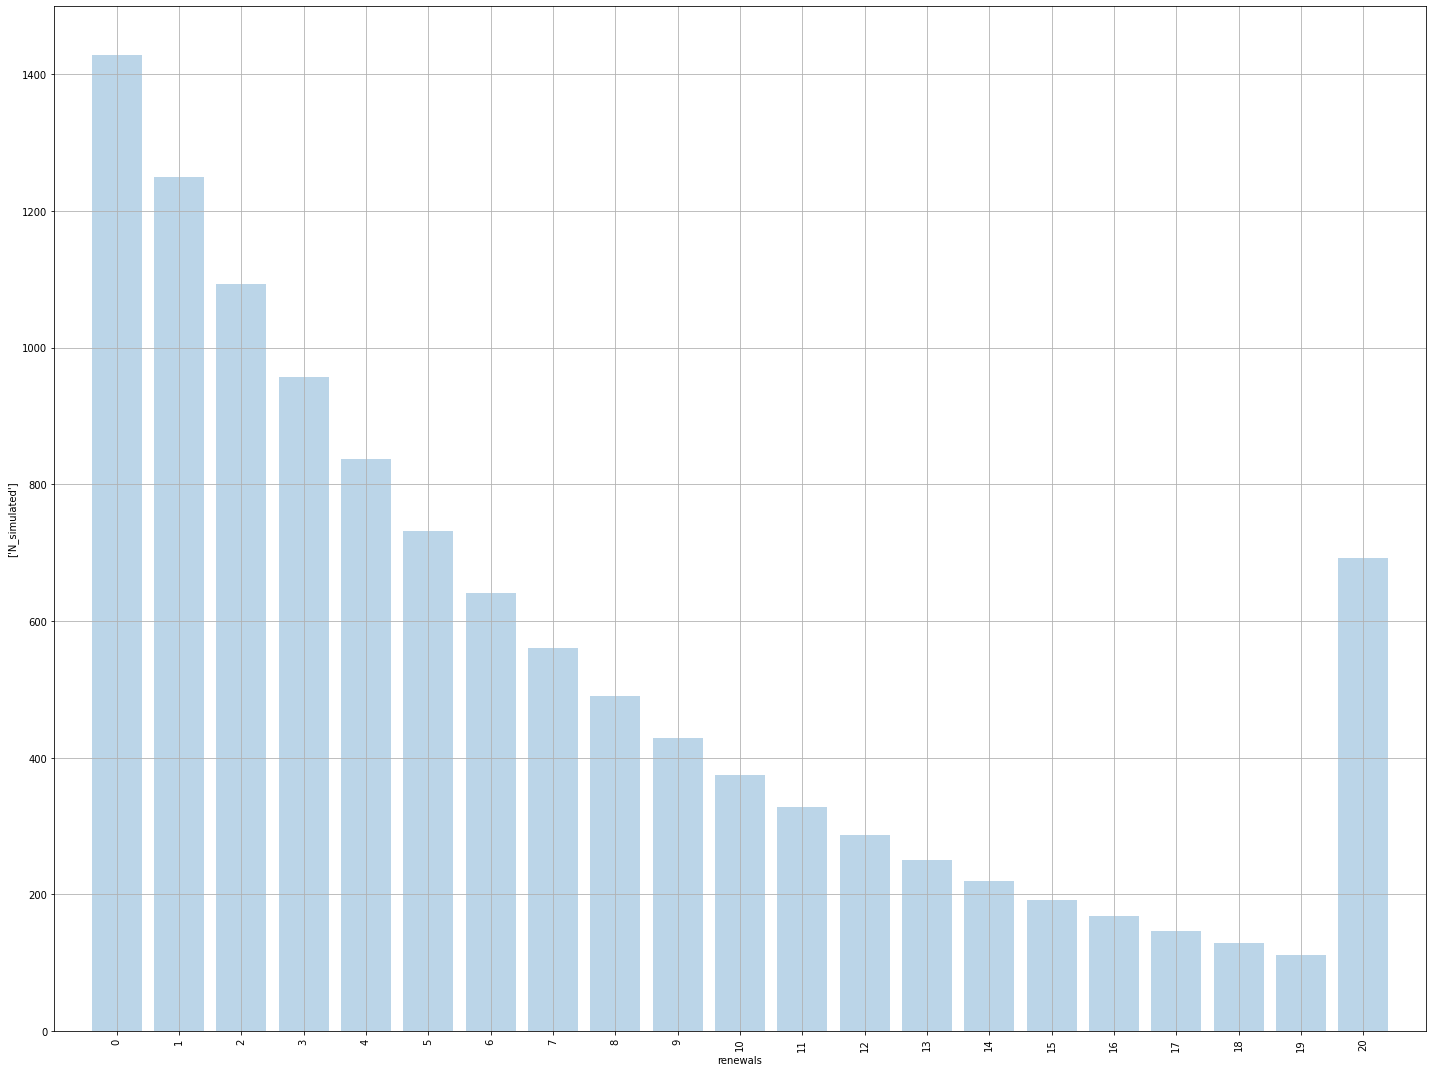

In [10]:
subscriptions_model.plot(simulations, columns=['N_simulated'])

The plot looks similar, but we used a random value of $p$. Now I'll use the data to find the best fit of $p$. For this task I used the scipy.optimize package.

In [11]:
X = data_subscriptions['renewals'].values
y = (data_subscriptions['N'].values)/sum(data_subscriptions['N'])

In [12]:
p = subscriptions_model.fit(X, y)
logger.info(f"Best fit: p = {p}")

28/03/2021 08:28:41PM - INFO - Best fit: p = 0.0611821420537749


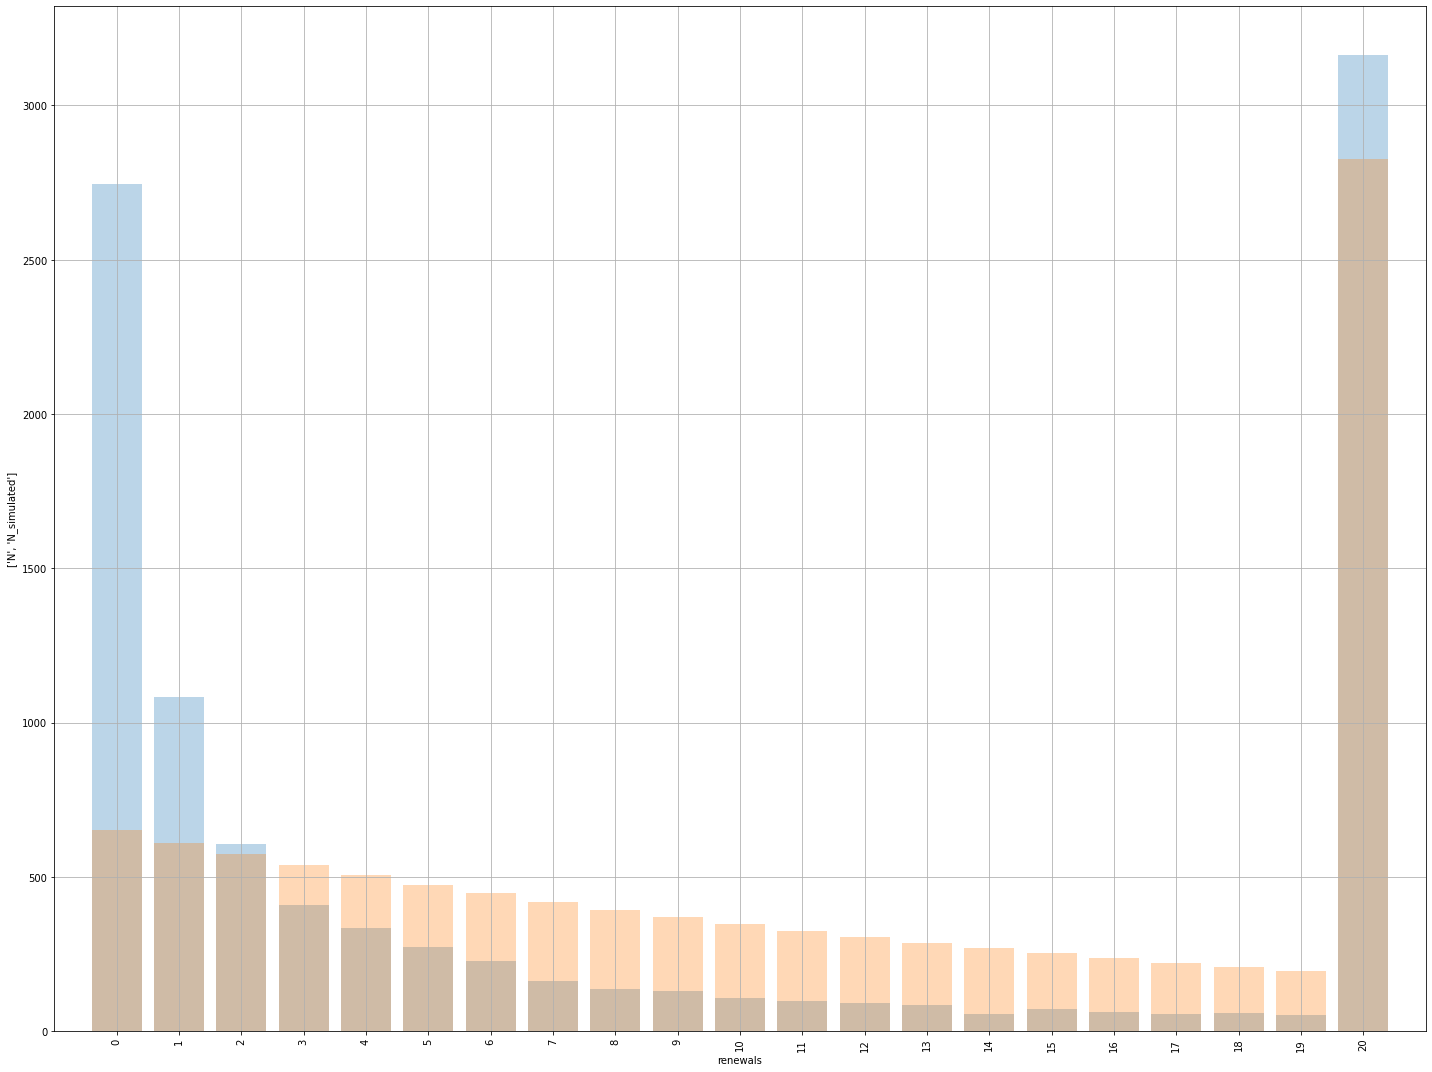

In [13]:
simulations = subscriptions_model.simulate(p=p, T=20, N_customers=10000)
subscriptions_model.plot(simulations.merge(data_subscriptions), columns=['N', 'N_simulated'])

The two plot are pretty different. I think that the hypotesized model is too much simplyfied for the problem we are trying to describe.
The model assumes that the unsubscription probability is the same for each customer and constant in time. 

Maybe a better way to handle this problem would be to build a machine learning model to find a user-specific unsuscribing propensity.

# Machine Learning Challenge - Solution

This notebook contains the solution of the challange and some explanation.

And now some python models that I wrote (you'll find them in the source folder):

In [14]:
from source.featureExtractor import FeatureExtraxtor
from source.model import MLmodel

## Import dataset from CSV

I saved the input data in the data folder, now I am defining the relative path

In [15]:
train_path = os.path.join('data', "train.csv")

In the featureExtractor.py module I defined a class that contains all the method that I used to preprocess the data. Now I am instatiating an element of this class. In the constructor it needs the path of the csv file with the data.

In [16]:
myFE = FeatureExtraxtor(train_path)

Now I will generate the features. I used different methods for each column or group of columns, you can read the docstrings and the comment in featureExtractor.py for all the details: 

In [17]:
features = myFE.getFeatures()
features.head()

28/03/2021 08:28:42PM - INFO - *** getting geographical features...
28/03/2021 08:28:43PM - INFO - *** getting delay features...
28/03/2021 08:28:43PM - INFO - *** getting device type features...
28/03/2021 08:28:43PM - INFO - *** getting calendar day features...
28/03/2021 08:28:50PM - INFO - *** getting gender features...
28/03/2021 08:28:50PM - INFO - *** getting age features...
28/03/2021 08:28:50PM - INFO - *** getting attribution network features...
28/03/2021 08:28:50PM - INFO - *** getting language features...
28/03/2021 08:28:50PM - INFO - *** getting numerical features...


,uid,is_from_US,is_from_GB,is_from_FR,is_from_CA,is_from_DE,is_from_AU,is_from_Asia,is_from_Europe,is_from_North America,...,attribution_network_Facebook Installs,attribution_network_Adwords UAC Installs,attribution_network_Apple Search Ads,language_english,language_french,language_german,language_spanish,product_price_tier,product_periodicity,net_purchases_15d
0,wBmGYN3Z+l3OBvdnzv/fdw==,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,20,30,0.00
1,s8j5KRaEXICNrKRsaBB8FQ==,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,6,7,4.20
2,YpCrTmFIkyrv/8Xv2hNJcw==,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,6,7,0.00
3,U8WfGbQJ5rtEuMARYiLkkA==,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,6,7,4.20
4,996ECqYkUl6anviM65Npxg==,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,6,7,4.13


## Model

In this section I will define and train the model.

As a first step, I am loading the target and merging it with our features dataset (to be sure that features and target of each uid are matching):

In [18]:
target = pd.read_csv(train_path)[['uid', 'net_purchases_1y']]
train_set = target.merge(features).set_index('uid')

I am defining now my X and y, to be given as input to the regression model:

In [19]:
X = train_set.drop(columns='net_purchases_1y')
y = train_set[['net_purchases_1y']]

To check any eventual overfitting problem, I will split bot the features and the target dataset into a train and a validation part.
I will then evaluate the rmse on both test, to check both the quality and the generalization ability of the model:

In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(X,
                                                    np.squeeze(y.values),
                                                    test_size=0.05)

For this challenge, I've tested several tree-based model. I defined them in a configuration file called model_settings.yaml, now I am importing that in the code:

In [21]:
with open(os.path.join('source', 'model_settings.yaml'), 'r', encoding="utf-8") as handler:
    model_params = yaml.load(handler, Loader=yaml.FullLoader)

Now I am defining an instance of a MLmodel object, a class defined in the model.py module (in the source folder) that contain several useful methods for dealing with tree based regression models.
I've choosen this class of models because they offer a great compromise between simplicity and quality of the predictios.

In [22]:
myRegModel = MLmodel(model_params['XGBoost'])

Now I am launching the optimization routine based on gridsearch or randomsearch (to be chosen in the configuration file).

In [23]:
myRegModel.optimize(X_train, y_train)

28/03/2021 08:28:51PM - INFO - * * * Optimizing hyperparameters
28/03/2021 08:28:51PM - INFO - * * * Launching the Random Search
28/03/2021 08:30:16PM - INFO - * * * * Optimal Hyperparameters: XGBRegressor(base_score=0.5, booster=None, boosting_type='rf',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.01, max_delta_step=0,
             max_depth=9, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=100, reg_lambda=1,
             scale_pos_weight=12.25, subsample=0.4, tree_method=None,
             validate_parameters=False, verbosity=None)
28/03/2021 08:30:16PM - INFO - * * * Hyperparameters optimized!


Finally, I am fitting the model:

In [24]:
myRegModel.fit(X_train, y_train)

Let's plot the features importances. Tree based models offer a simple method to check the relative importances of the features, so I think they are a great choice when (as in this case) who is writing the model doesn't have a solid understanding of the underlying business problem, so he need some insight about the goodness of the chosen features. In this case, I made several attempts and I deleted some features which importance were always 0. There are also automatic routines defined in scikit-learn to do this task (for example sklearn.feature_selection.RFE) but I didn't get good results with them.

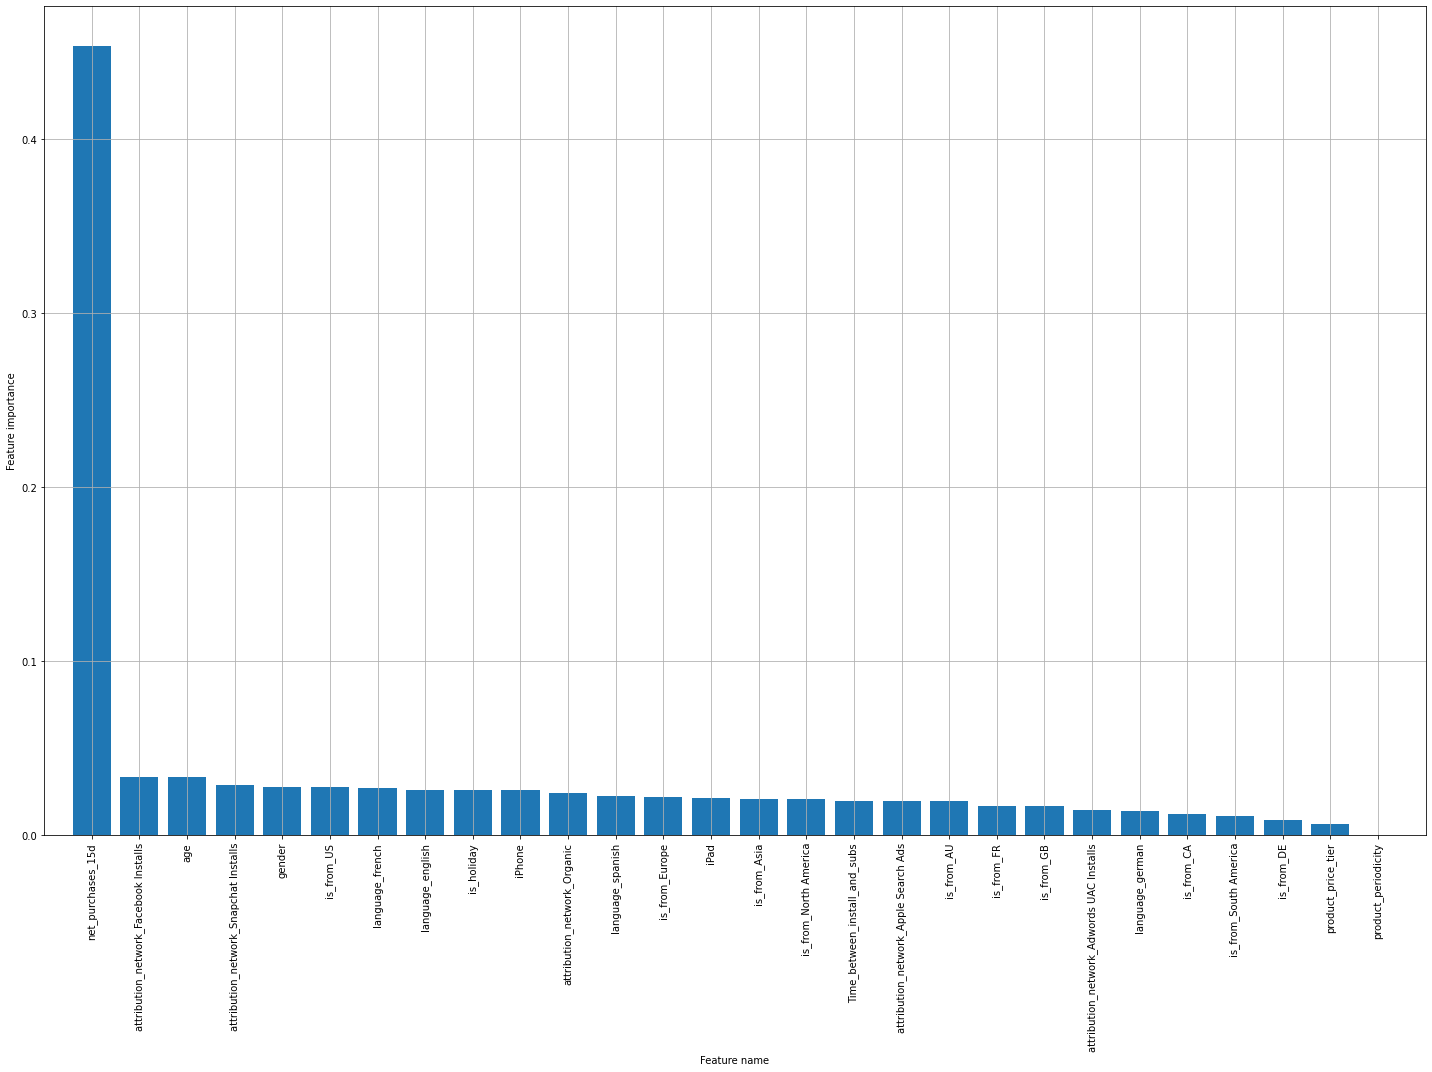

28/03/2021 08:30:20PM - INFO - 
--------- Feature Importance ---------
28/03/2021 08:30:21PM - INFO -  1) net_purchases_15d              0.453345
28/03/2021 08:30:21PM - INFO -  2) attribution_network_Facebook Installs 0.033390
28/03/2021 08:30:22PM - INFO -  3) age                            0.033287
28/03/2021 08:30:22PM - INFO -  4) attribution_network_Snapchat Installs 0.028824
28/03/2021 08:30:23PM - INFO -  5) gender                         0.027928
28/03/2021 08:30:23PM - INFO -  6) is_from_US                     0.027858
28/03/2021 08:30:24PM - INFO -  7) language_french                0.026902
28/03/2021 08:30:24PM - INFO -  8) language_english               0.026089
28/03/2021 08:30:25PM - INFO -  9) is_holiday                     0.025998
28/03/2021 08:30:25PM - INFO - 10) iPhone                         0.025939
28/03/2021 08:30:26PM - INFO - 11) attribution_network_Organic    0.024398
28/03/2021 08:30:26PM - INFO - 12) language_spanish               0.022279
28/03/2021 08:3

In [25]:
myRegModel.plotFeaturesImportances(X.columns)

Now I am assembling the predictions:

In [26]:
y_pred_train = myRegModel.predict(X_train)
y_pred_validation =  myRegModel.predict(X_validation)

Let's see the RMSE of this model.

In [27]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_train = rmse(y_train, y_pred_train)
rmse_valid = rmse(y_validation, y_pred_validation)


logger.info(f"RMSE: {rmse_train} (train set)")
logger.info(f"RMSE: {rmse_valid} (validation set)")

28/03/2021 08:30:35PM - INFO - RMSE: 11.988330911496526 (train set)
28/03/2021 08:30:35PM - INFO - RMSE: 12.805273345283068 (validation set)


The RSME is pretty similar in train and validation set, so we can conclude that the model didn't overfit. 

My performances are slightly better than the simple linear model you provided as example.

I think that we can explain this with the fact that ''net_purchases_15d'', the regression variable you used, is by far the most important feature according to the above list, so even a linear model who uses just that can give excellent results.

## Export CSV for submission

I am exporting the csv file with the prediction on the test set in the data folder:

In [28]:
test_path = os.path.join('data', "test.csv")
myFE = FeatureExtraxtor(test_path)
X_test = myFE.getFeatures().set_index('uid')
y_pred_test = myRegModel.predict(X_test)
df_candidate = pd.DataFrame({"y_pred_test": y_pred_test})
df_candidate.to_csv('submission.csv', index=False)

28/03/2021 08:30:35PM - INFO - *** getting geographical features...
28/03/2021 08:30:35PM - INFO - *** getting delay features...
28/03/2021 08:30:35PM - INFO - *** getting device type features...
28/03/2021 08:30:35PM - INFO - *** getting calendar day features...
28/03/2021 08:30:37PM - INFO - *** getting gender features...
28/03/2021 08:30:37PM - INFO - *** getting age features...
28/03/2021 08:30:37PM - INFO - *** getting attribution network features...
28/03/2021 08:30:37PM - INFO - *** getting language features...
28/03/2021 08:30:37PM - INFO - *** getting numerical features...


## Answers

### Which model did you choose and why?

I've restricted my choice to tree-based models, because they offer good performances (expecially when the size of the dataset is pretty small, as in this case) and an easy way to rank the importance of the features.

### What are the most predictive features?

There is essentially just one most predictive feature, the net purchases in the first 15 days. Anyway, the full list is reported in the previous section.

### How did you handle outliers and missing values in the dataset?

It depends feature by feature, sometimes I replaced the missing value with the column mean (I used this strategy for numerical features), sometimes I encoded the missing/invalid data with a custom label. The details are reported in the featureExtractor.py module.

### Would it be possible to improve the model's performance by adding more data available in the first 15 days since subscription?

The model performs poorly, so I guess that the answer is yes. Anyway, I lack the business experience in the field to know in advance wich feature will help to improve the predictions.

### Did you discover any non-trivial insights in the data which could help you build a better model?

No, I noticed that taking into account more features give us a slightly better model, but the resulting rmse is just a little smaller than the simple linear model that take into account just the most relevant feature. This means that the independent variable is mostly explained by this feature and in a simple (linear) way.